In [1]:
import numpy as np
import torch
from ADEN import ADEN
import torchsummary
from TestCaseGenerator import data_RLClustering
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def d_t(x, y):
    return 0.5 * torch.sum((x - y)** 2) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1800, 64]             192
            Linear-2                [-1, 4, 64]             192
            Linear-3             [-1, 1800, 64]           4,096
            Linear-4                [-1, 4, 64]           4,096
            Linear-5                [-1, 4, 64]           4,096
           Dropout-6           [-1, 8, 1800, 4]               0
            Linear-7             [-1, 1800, 64]           4,160
MultiHeadDistanceAttention-8             [-1, 1800, 64]               0
           Dropout-9             [-1, 1800, 64]               0
        LayerNorm-10             [-1, 1800, 64]             128
           Linear-11            [-1, 1800, 128]           8,320
             GELU-12            [-1, 1800, 128]               0
          Dropout-13            [-1, 1800, 128]               0
           Linear-14           

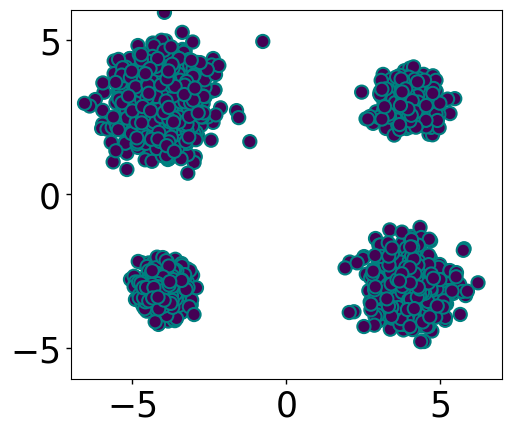

In [3]:

X, M, T_P, N, d = data_RLClustering(4)
X = torch.tensor(X).to(device)

Batch_size = 16 # number of batches
num_samples_in_batch = 8 # number of samples in each batch
input_dim = d # dimensionality of the input space


Y = torch.mean(X, dim=0).to(device) + torch.randn(M, input_dim).to(device)  # example cluster tensor (M, input_dim)

model = ADEN(input_dim=input_dim, d_model=64, n_layers=3, d_ff=128).to(device)

torchsummary.summary(model, [(N, input_dim), (M, input_dim)])
# visualize the model architecture


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

Y_batches = (
    Y.unsqueeze(0).expand(Batch_size, -1, -1).to(device)
)  # (Batch_size, M, input_dim)
for epoch in range(1000):  # example training loop

    X_batches = torch.zeros(Batch_size, num_samples_in_batch, input_dim).to(
        device
    )  # (Batch_size, num_samples_in_batch, input_dim)
    for i in range(Batch_size):
        batch_indices = torch.randint(0, N, (num_samples_in_batch,)).to(device)
        X_batches[i] = X[batch_indices]

    predicted_distances = model(
        X_batches, Y_batches
    )  # predicted distances (Batch_size, num_samples_in_batch, M)
    idx = torch.argmin(
        predicted_distances, dim=-1
    ).long()  # indices of the closest clusters (Batch_size, num_samples_in_batch)
    # create a mask of chosen indices to only include them in the training error
    mask = torch.zeros_like(predicted_distances, dtype=torch.bool)
    mask.scatter_(2, idx.unsqueeze(2), 1)  # (Batch_size, num_samples_in_batch, M)
    gamma = 1000.0
    transition_probs = torch.exp(-gamma * torch.cdist(Y, Y, p=2) ** 2)  # (M, M)
    transition_probs = transition_probs / transition_probs.sum(dim=-1, keepdim=True)
    D = torch.zeros(Batch_size, num_samples_in_batch, M).to(
        device
    )  # (Batch_size, num_samples_in_batch)
    for b in range(Batch_size):
        for i in range(num_samples_in_batch):
            realized_cluster = torch.multinomial(transition_probs[idx[b][i]], 1).item()
            D[b][i][idx[b][i]] = d_t(X_batches[b][i], Y_batches[b][realized_cluster])
    # take MSE error between D and predicted_distances only when mask is true
    mse_loss = torch.sum((D[mask] - predicted_distances[mask]) ** 2)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, MSE Loss: {mse_loss.item()}")
    optimizer.zero_grad()
    mse_loss.backward()
    optimizer.step()

Epoch 0, MSE Loss: 0.5455880165100098
Epoch 100, MSE Loss: 0.46677589416503906
Epoch 200, MSE Loss: 0.07816317677497864
Epoch 300, MSE Loss: 0.030827898532152176
Epoch 400, MSE Loss: 0.027959149330854416
Epoch 500, MSE Loss: 0.02114732563495636
Epoch 600, MSE Loss: 0.018745094537734985
Epoch 700, MSE Loss: 0.015843786299228668
Epoch 800, MSE Loss: 0.007767817936837673
Epoch 900, MSE Loss: 0.01370911579579115


In [6]:
y_to_be_optimized = Y.clone().detach().requires_grad_(True)  # make Y a parameter to be optimized
# fix model weights
for param in model.parameters():
    param.requires_grad = False
model.eval()

ADEN(
  (data_projection): Linear(in_features=2, out_features=64, bias=True)
  (cluster_projection): Linear(in_features=2, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-2): 3 x AdaptiveDistanceBlock(
      (attention): MultiHeadDistanceAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=False)
        (W_k): Linear(in_features=64, out_features=64, bias=False)
        (W_v): Linear(in_features=64, out_features=64, bias=False)
        (W_o): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.1, inplace=False)
 

In [21]:
optimizer_y = torch.optim.AdamW([y_to_be_optimized], lr=1e-3, weight_decay=1e-5)

beta = 1000
F_old = torch.tensor(float('inf'), device=device)  # Initialize F_old to a large value
epoch = 0
while True:
    # Update y_to_be_optimized using the gradients
    d_s = model(X.unsqueeze(0), y_to_be_optimized.unsqueeze(0))[0] # (N, M)
    F = -1/beta*torch.sum(torch.log(torch.sum(torch.exp(-beta*d_s), dim=-1)))
    optimizer_y.zero_grad()
    F.backward()
    optimizer_y.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, F: {F.item()}")
    if torch.norm(F_old - F)/torch.norm(F_old) < 1e-6:
        break
    F_old = F.clone()  # Update F_old for the next iteration
    epoch += 1

Epoch 0, F: 25.118270874023438


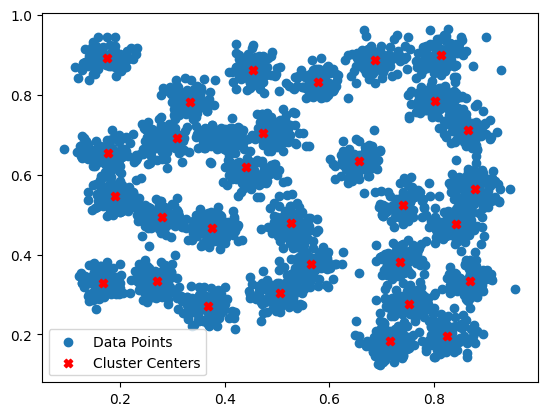

In [22]:
# plot locations of X and final y
import matplotlib.pyplot as plt
# converting results to numpy
X_np = X.detach().cpu().numpy()
y_np = y_to_be_optimized.detach().cpu().numpy()
plt.scatter(X_np[:, 0], X_np[:, 1], label='Data Points')
plt.scatter(y_np[:, 0], y_np[:, 1], label='Cluster Centers', marker='X', color='red')
plt.legend()
plt.show()

In [23]:
model(X.unsqueeze(0), y_to_be_optimized.unsqueeze(0))[0]

tensor([[0.1991, 0.1423, 0.1202,  ..., 0.2433, 0.0307, 0.3001],
        [0.1923, 0.1528, 0.1076,  ..., 0.2246, 0.0270, 0.2862],
        [0.1931, 0.1409, 0.1141,  ..., 0.2346, 0.0281, 0.2917],
        ...,
        [0.0638, 0.0325, 0.1277,  ..., 0.1277, 0.1813, 0.0937],
        [0.0588, 0.0232, 0.1134,  ..., 0.1230, 0.1556, 0.0947],
        [0.0432, 0.0250, 0.0982,  ..., 0.0968, 0.1546, 0.0695]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [24]:
0.5*torch.cdist(X, y_to_be_optimized, p=2)**2

tensor([[0.1908, 0.1332, 0.1121,  ..., 0.2356, 0.0221, 0.2922],
        [0.1842, 0.1438, 0.0996,  ..., 0.2169, 0.0185, 0.2784],
        [0.1849, 0.1318, 0.1061,  ..., 0.2269, 0.0196, 0.2838],
        ...,
        [0.0570, 0.0251, 0.1211,  ..., 0.1213, 0.1743, 0.0872],
        [0.0519, 0.0156, 0.1067,  ..., 0.1165, 0.1485, 0.0881],
        [0.0364, 0.0176, 0.0915,  ..., 0.0904, 0.1476, 0.0630]],
       device='cuda:0', grad_fn=<MulBackward0>)